In [1]:
import os

import numpy as np
import pandas as pd
import featuretools as ft
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
import missingno as msno

sns.set(font_scale=1.5, rc={"figure.figsize": (12, 8)})

In [2]:
def distplot(series, **kwargs):
    """Create a figure with two subplots.
    The lower part of the figure is distplot and the upper part display
    a box plot for the same sample.

    :arg:
        series (pd.Series): The sample you want to plot.
        kwargs : all keyword argument accepted by seaborn.distplot.
    """
    # Cut the window in 2 parts
    kwrgs = {"height_ratios": (.15, .85)}
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(8, 8),
                                        gridspec_kw=kwrgs)

    # Add a graph in each part
    sns.boxplot(series, ax=ax_box)
    sns.distplot(series, ax=ax_hist, **kwargs)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    return ax

## Data loading

In [3]:
data = dict()
for dirname, _, filenames in os.walk('../data/raw'):
    for filename in filenames:
        print(filename)

application_test.csv
application_train.csv
bureau.csv
bureau_balance.csv
credit_card_balance.csv
HomeCredit_columns_description.csv
installments_payments.csv
POS_CASH_balance.csv
previous_application.csv
sample_submission.csv


**Liens entre les fichiers**

![kaggle](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)


In [4]:
app_train = pd.read_csv('../data/raw/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
app_test = pd.read_csv('../data/raw/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Exploratory data analysis

### Target distribution

In [6]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

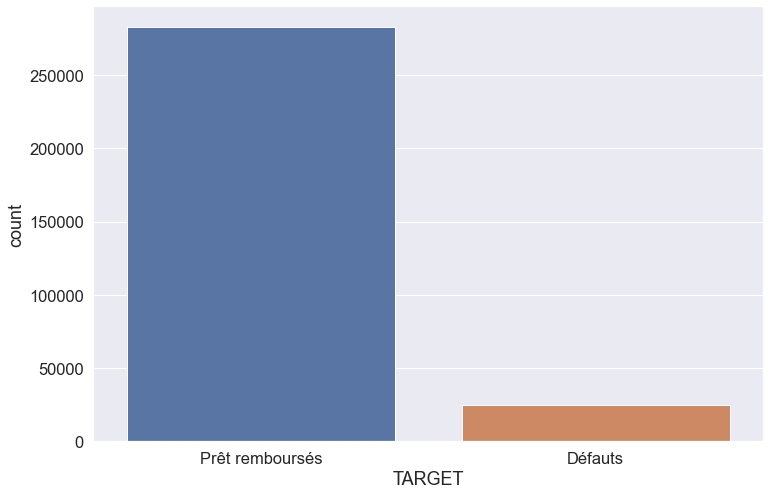

In [7]:
fig, ax = plt.subplots(1, figsize=(12, 8))
sns.countplot(app_train['TARGET'])
plt.xticks(ticks=[0, 1], labels=['Prêt remboursés', 'Défauts'])
plt.show()

### missing values

In [8]:
incomplete = list()
for col in app_train.columns:
    if app_train[col].isna().any():
        incomplete.append(col)
        
print('the dataframe contains %i columns with missing values' % len(incomplete))

the dataframe contains 67 columns with missing values


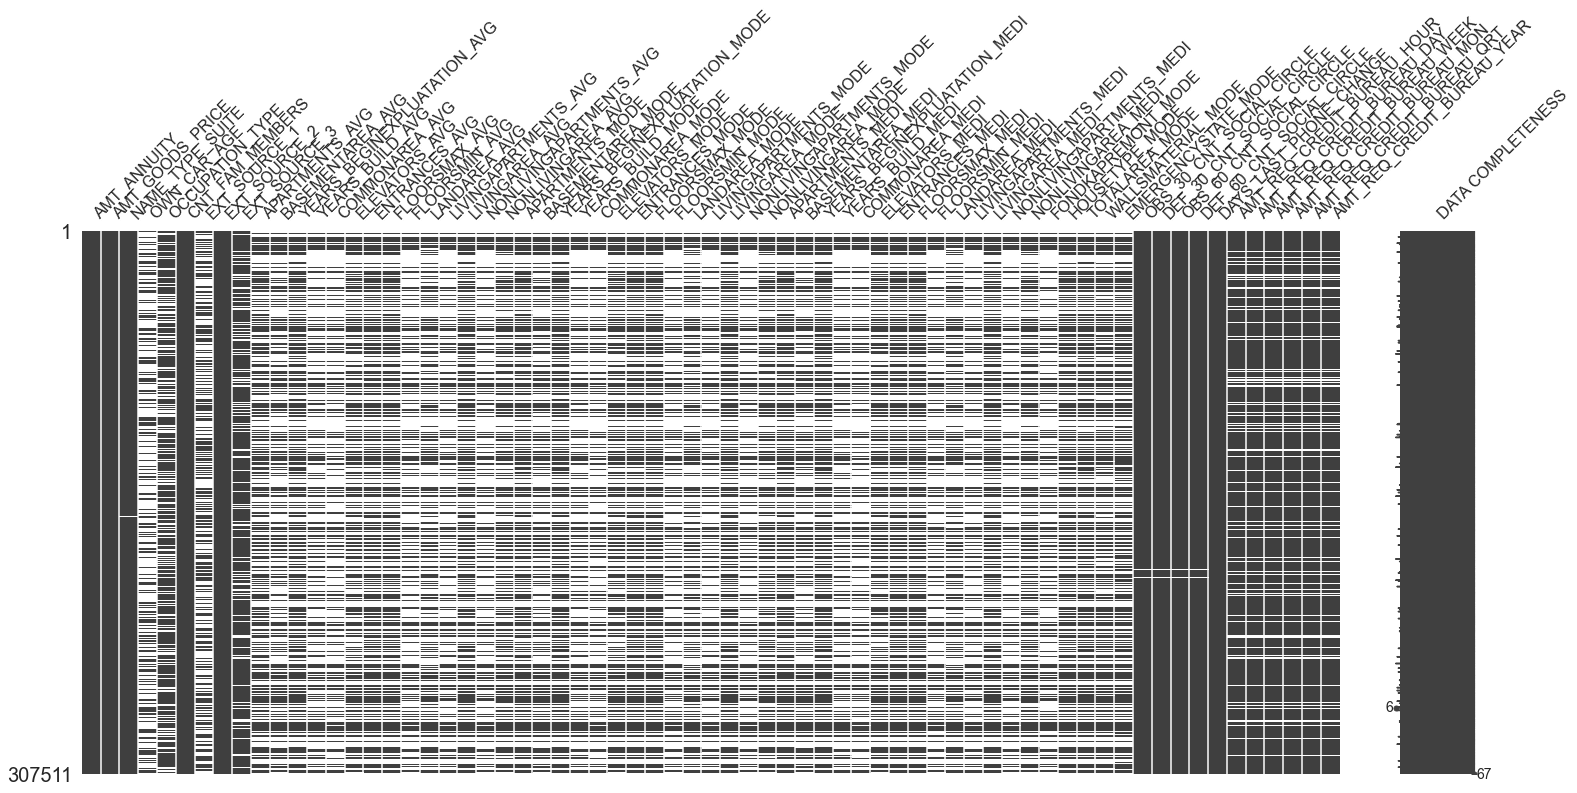

In [9]:
msno.matrix(app_train[incomplete], labels=True)

In [10]:
completeness = pd.DataFrame(app_train.isnull().sum(), columns=['missing values'])
completeness['% of missing'] = (completeness['missing values'] / len(app_train) * 100)
completeness.sort_values('% of missing', ascending=False)

,missing values,% of missing
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
...,...,...
NAME_HOUSING_TYPE,0,0.000000
NAME_FAMILY_STATUS,0,0.000000
NAME_EDUCATION_TYPE,0,0.000000
NAME_INCOME_TYPE,0,0.000000


### column types

In [11]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

### categorical variables

In [12]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### Label encoding and One-Hot Encoding

In [13]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [14]:
le = LabelEncoder()
le_ = 0

for col in app_train.columns:
    if app_train[col].dtype.name == 'object':
        if len(app_train[col].unique()) <= 2:
            # label encoder
            print('Encoding %s' % col)
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            le_ += 1

print(f"{le_} columns encoded")

Encoding NAME_CONTRACT_TYPE
Encoding FLAG_OWN_CAR
Encoding FLAG_OWN_REALTY
3 columns encoded


In [15]:
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

In [16]:
app_train.shape

(307511, 243)

In [17]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 243 entries, SK_ID_CURR to EMERGENCYSTATE_MODE_Yes
dtypes: float64(65), int32(3), int64(41), uint8(134)
memory usage: 291.5 MB


In [18]:
train_labels = app_train['TARGET']
app_train, app_test = app_train.align(app_test, join='inner', axis=1)
app_train['TARGET'] = train_labels

print(f'Train set shape : {app_train.shape}')
print(f'Test set shape : {app_test.shape}')

Train set shape : (307511, 240)
Test set shape : (48744, 239)


In [19]:
app_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0,0,0,0,0,1,0,1,0,1
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,1,0,0,0,0,0,0,1,0,0
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0,0,0,0,0,0,0,0,0,0


In [20]:
app_train[app_train['TARGET'] == 1]

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0,0,0,0,0,1,0,1,0,1
26,100031,0,0,1,0,112500.0,979992.0,27076.5,702000.0,0.018029,...,0,0,0,0,0,0,1,0,1,1
40,100047,0,0,1,0,202500.0,1193580.0,35028.0,855000.0,0.025164,...,0,0,0,0,0,1,0,1,0,1
42,100049,0,0,0,0,135000.0,288873.0,16258.5,238500.0,0.007305,...,0,0,0,0,0,0,0,0,0,1
81,100096,0,0,1,0,81000.0,252000.0,14593.5,252000.0,0.028663,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307448,456186,0,0,0,1,207000.0,450000.0,32746.5,450000.0,0.020246,...,0,0,0,0,0,1,0,1,0,1
307475,456215,0,0,0,1,144000.0,1303200.0,46809.0,1125000.0,0.007330,...,0,0,0,0,1,0,0,1,0,1
307481,456225,0,0,1,0,225000.0,297000.0,19975.5,297000.0,0.008575,...,0,0,0,0,0,0,0,0,0,1
307489,456233,0,0,1,0,225000.0,521280.0,23089.5,450000.0,0.014464,...,0,0,0,0,0,1,0,0,1,1


In [21]:
app_train[app_train['TARGET'] == 0]

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,1,0,0,0,0,0,0,1,0,0
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0,0,0,0,0,0,0,0,0,0
5,100008,0,0,1,0,99000.0,490495.5,27517.5,454500.0,0.035792,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307505,456249,0,0,1,0,112500.0,225000.0,22050.0,225000.0,0.022800,...,0,0,0,0,1,0,0,1,0,0
307506,456251,0,0,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,...,0,0,0,0,0,1,0,1,0,0
307507,456252,0,0,1,0,72000.0,269550.0,12001.5,225000.0,0.025164,...,0,0,0,0,0,1,0,1,0,0
307508,456253,0,0,1,0,153000.0,677664.0,29979.0,585000.0,0.005002,...,0,0,0,0,1,0,0,1,0,0


### Anomalies

### Correlations

In [22]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

In [23]:
correlations.tail(15)

DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

In [24]:
correlations.head(15)

EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
ORGANIZATION_TYPE_XNA                  -0.045987
DAYS_EMPLOYED                          -0.044932
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
FLOORSMAX_MODE                         -0.043226
EMERGENCYSTATE_MODE_No                 -0.042201
HOUSETYPE_MODE_block of flats          -0.040594
AMT_GOODS_PRICE                        -0.039645
REGION_POPULATION_RELATIVE             -0.037227
Name: TARGET, dtype: float64

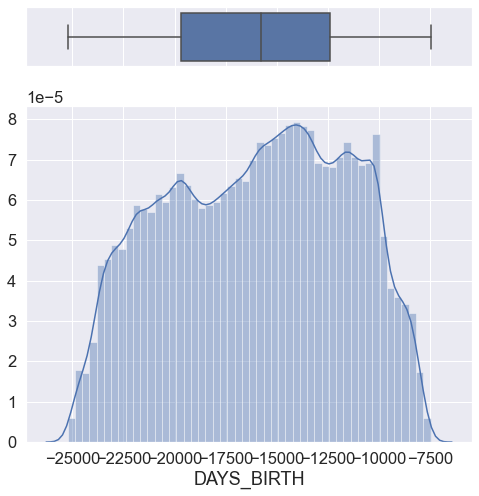

In [25]:
distplot(app_train['DAYS_BIRTH'])
plt.show()

Text(0, 0.5, 'freq')

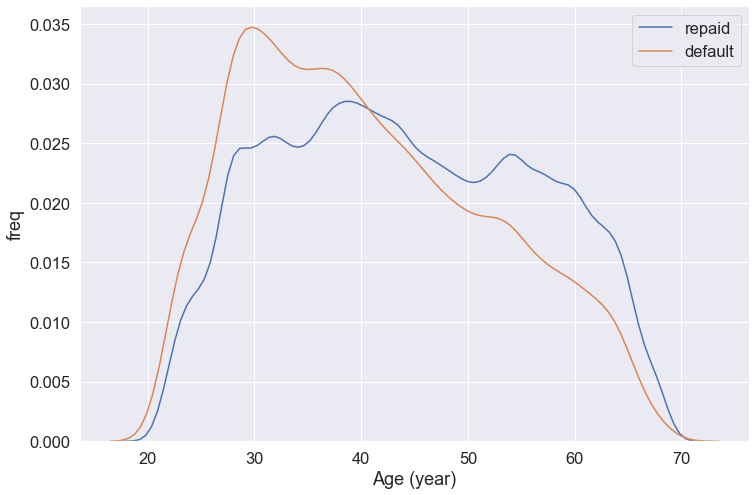

In [26]:
app_train['DAYS_BIRTH'] = np.abs(app_train['DAYS_BIRTH'])
sns.kdeplot(app_train[app_train['TARGET'] == 0]['DAYS_BIRTH'] / 365, label='repaid')
sns.kdeplot(app_train[app_train['TARGET'] == 1]['DAYS_BIRTH'] / 365, label='default')
plt.xlabel('Age (year)')
plt.ylabel('freq')

In [27]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [28]:
age_groups_count = age_data.groupby('TARGET')\
                        .apply(lambda x: x.groupby('YEARS_BINNED')\
                               .count()).drop(columns='TARGET').reset_index(drop=False)

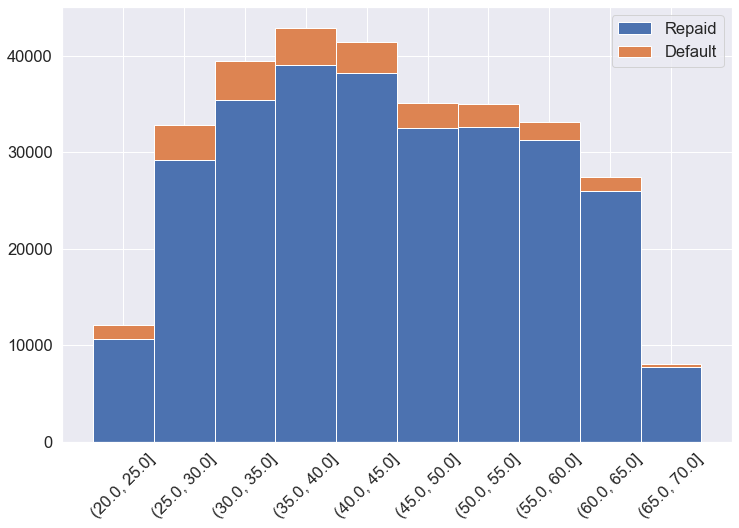

In [29]:
plt.bar(x=age_groups_count[age_groups_count['TARGET'] == 0]['YEARS_BINNED'].values.astype('str'),
        height=age_groups_count[age_groups_count['TARGET'] == 0]['DAYS_BIRTH'], label='Repaid', width=1)
plt.bar(x=age_groups_count[age_groups_count['TARGET'] == 1]['YEARS_BINNED'].values.astype('str'),
        height=age_groups_count[age_groups_count['TARGET'] == 1]['DAYS_BIRTH'], label='Default', width=1, 
        bottom=age_groups_count[age_groups_count['TARGET'] == 0]['DAYS_BIRTH'])
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [30]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


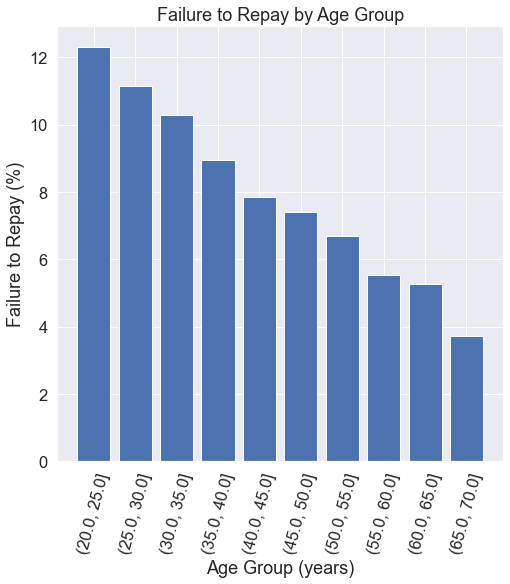

In [31]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

In [32]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


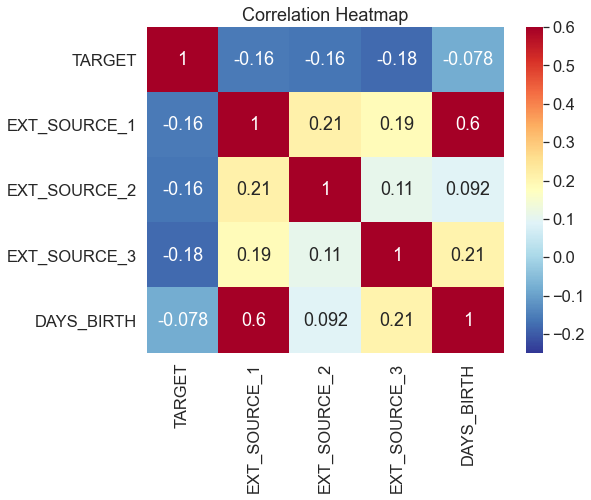

In [33]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap');

## Baseline : régression logistique

In [34]:
target = app_train['TARGET']
features = list(app_train.columns)

test = app_test.copy()
train = app_train.copy().drop(columns=['TARGET'])

imputer = SimpleImputer(strategy='median')
scaler = MinMaxScaler(feature_range=(0, 1))

imputer.fit(train)

train = imputer.transform(train)
test = imputer.transform(test)

scaler.fit(train)

train = scaler.transform(train)
test = scaler.transform(test)

print(f'train set shape : {train.shape}')
print(f'test set shape : {test.shape}')

train set shape : (307511, 239)
test set shape : (48744, 239)


In [35]:
reg = LogisticRegression(C=1e-4)
reg.fit(train, target)

LogisticRegression(C=0.0001)

In [36]:
baseline_results = app_test[['SK_ID_CURR']]
baseline_results['TARGET'] = reg.predict_proba(test)[:, 1]

In [37]:
baseline_results.head()

,SK_ID_CURR,TARGET
0,100001,0.078578
1,100005,0.138925
2,100013,0.082828
3,100028,0.080896
4,100038,0.132868


In [38]:
path = os.path.join(os.path.abspath('../reports/'), 'logistic_reg_baseline.csv')
baseline_results.to_csv(path, index=False)

### Baseline results :

**Score 0.67789**

A ce stade là, seul un fichier a été exploité. Il est quand même intéressant de voir que l'on atteind un score *ROC_AUC* de 0.68.

*ROC_AUC: Rappel* ![wiki](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/ROC_curves.svg/1280px-ROC_curves.svg.png)

## Exploration des autres fichiers

 * **bureau.csv**

    * All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
    * For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

 * **bureau_balance.csv**

    * Monthly balances of previous credits in Credit Bureau.
    * This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

 * **POS_CASH_balance.csv**

    * Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
    * This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

 * **credit_card_balance.csv**

    * Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
    * This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

 * **previous_application.csv**

    * All previous applications for Home Credit loans of clients who have loans in our sample.
    * There is one row for each previous application related to loans in our data sample.

    * Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
    * There is a) one row for every payment that was made plus b) one row each for missed payment.
    * One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.
 
 
 Rappel:
 
 **Liens entre les fichiers**

![kaggle](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

 

In [39]:
bureau = pd.read_csv('../data/raw/bureau.csv')\
    .sort_values(['SK_ID_CURR', 'SK_ID_BUREAU'])\
    .reset_index(drop=True)
bureau_balance = pd.read_csv('../data/raw/bureau_balance.csv')\
    .sort_values('SK_ID_BUREAU')\
    .reset_index(drop=True)
cash = pd.read_csv('../data/raw/POS_CASH_balance.csv')\
    .sort_values(['SK_ID_CURR', 'SK_ID_PREV'])\
    .reset_index(drop=True)
credit = pd.read_csv('../data/raw/credit_card_balance.csv')\
    .sort_values(['SK_ID_CURR', 'SK_ID_PREV'])\
    .reset_index(drop=True)
previous = pd.read_csv('../data/raw/previous_application.csv')\
    .sort_values(['SK_ID_CURR', 'SK_ID_PREV'])\
    .reset_index(drop=True)
installments = pd.read_csv('../data/raw/installments_payments.csv')\
    .sort_values(['SK_ID_CURR', 'SK_ID_PREV'])\
    .reset_index(drop=True)

In [40]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,100001,5896630,Closed,currency 1,-857,0,-492.0,-553.0,NaN,0,112500.0,0.0,0.0,0.0,Consumer credit,-155,0.0
1,100001,5896631,Closed,currency 1,-909,0,-179.0,-877.0,NaN,0,279720.0,0.0,0.0,0.0,Consumer credit,-155,0.0
2,100001,5896632,Closed,currency 1,-879,0,-514.0,-544.0,NaN,0,91620.0,0.0,0.0,0.0,Consumer credit,-155,0.0
3,100001,5896633,Closed,currency 1,-1572,0,-1329.0,-1328.0,NaN,0,85500.0,0.0,0.0,0.0,Consumer credit,-155,0.0
4,100001,5896634,Active,currency 1,-559,0,902.0,NaN,NaN,0,337680.0,113166.0,0.0,0.0,Consumer credit,-6,4630.5


### Customers's history

In [41]:
bureau['CREDIT_ACTIVE'].unique()

array(['Closed', 'Active', 'Sold', 'Bad debt'], dtype=object)

In [42]:
bureau['CREDIT_ACTIVE'].value_counts()

Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64

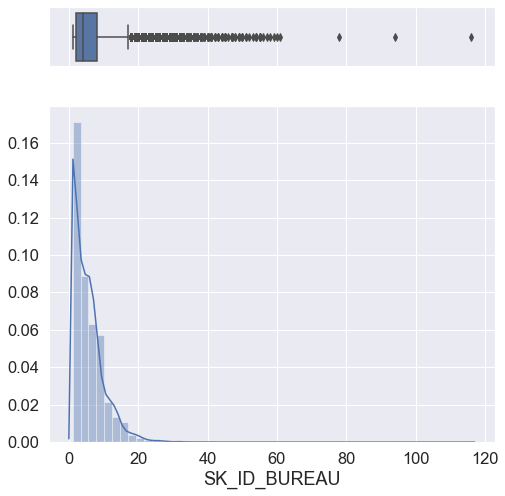

In [43]:
# distribution of the total number of past or/and actual credits per client
distplot(bureau.groupby('SK_ID_CURR').count()['SK_ID_BUREAU'])
plt.show()

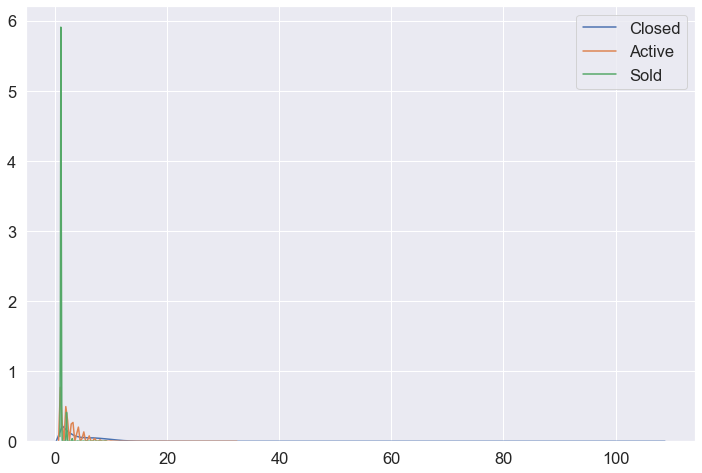

In [44]:
sns.kdeplot(bureau[bureau['CREDIT_ACTIVE'] == 'Closed'].groupby('SK_ID_CURR').count()['SK_ID_BUREAU'], label='Closed')
sns.kdeplot(bureau[bureau['CREDIT_ACTIVE'] == 'Active'].groupby('SK_ID_CURR').count()['SK_ID_BUREAU'], label='Active')
sns.kdeplot(bureau[bureau['CREDIT_ACTIVE'] == 'Sold'].groupby('SK_ID_CURR').count()['SK_ID_BUREAU'], label='Sold')


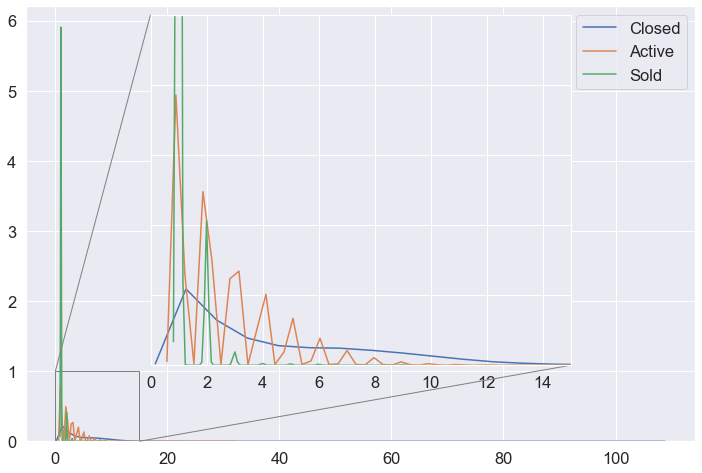

In [45]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes

fig, ax = plt.subplots()
sns.kdeplot(bureau[bureau['CREDIT_ACTIVE'] == 'Closed'].groupby('SK_ID_CURR').count()['SK_ID_BUREAU'], 
            label='Closed', ax=ax)
sns.kdeplot(bureau[bureau['CREDIT_ACTIVE'] == 'Active'].groupby('SK_ID_CURR').count()['SK_ID_BUREAU'], 
            label='Active', ax=ax)
sns.kdeplot(bureau[bureau['CREDIT_ACTIVE'] == 'Sold'].groupby('SK_ID_CURR').count()['SK_ID_BUREAU'], 
            label='Sold', ax=ax)

axins = zoomed_inset_axes(ax, 5, loc='upper center')

axins.set_xlim(0, 15) # apply the x-limits
axins.set_ylim(0, 1) # apply the y-limits

sns.kdeplot(bureau[bureau['CREDIT_ACTIVE'] == 'Closed'].groupby('SK_ID_CURR').count()['SK_ID_BUREAU'], 
            label=None, ax=axins)
sns.kdeplot(bureau[bureau['CREDIT_ACTIVE'] == 'Active'].groupby('SK_ID_CURR').count()['SK_ID_BUREAU'], 
            label=None, ax=axins)
sns.kdeplot(bureau[bureau['CREDIT_ACTIVE'] == 'Sold'].groupby('SK_ID_CURR').count()['SK_ID_BUREAU'], 
            label=None, ax=axins)

plt.yticks(visible=False)
plt.xticks(visible=True)

axins.legend_.remove()

mark_inset(ax, axins, loc1=2, loc2=4, fc='none', ec='0.5')

plt.show()

In [46]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5001709,-7,C
1,5001709,-3,C
2,5001709,-4,C
3,5001709,-5,C
4,5001709,-6,C


In [47]:
bureau_balance.describe()

,SK_ID_BUREAU,MONTHS_BALANCE
count,2.729992e+07,2.729992e+07
mean,6.036297e+06,-3.074169e+01
std,4.923489e+05,2.386451e+01
min,5.001709e+06,-9.600000e+01
25%,5.730933e+06,-4.600000e+01
50%,6.070821e+06,-2.500000e+01
75%,6.431951e+06,-1.100000e+01
max,6.842888e+06,0.000000e+00


In [48]:
bureau_balance[bureau_balance['SK_ID_BUREAU'] == 5001709]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5001709,-7,C
1,5001709,-3,C
2,5001709,-4,C
3,5001709,-5,C
4,5001709,-6,C
...,...,...,...
92,5001709,-68,C
93,5001709,-67,C
94,5001709,-66,C
95,5001709,-74,C


In [49]:
bureau_balance['STATUS'].value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

Status of Credit Bureau loan during the month (active, closed, DPD0-30,… [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,… 5 means DPD 120+ or sold or written off ] )

DPD (Days past due)

### Récapitulons

In [50]:
# select 5 customers from the main table
sample = app_train.sample(5, random_state=20)

In [51]:
sample

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
90298,204829,0,0,0,0,171000.0,518562.0,22099.5,463500.0,0.004960,...,0,0,0,0,0,0,0,1,0,0
253229,393025,1,1,1,0,247500.0,292500.0,14625.0,292500.0,0.014464,...,0,0,0,0,1,0,0,1,0,0
132761,253983,1,0,1,1,58500.0,157500.0,7875.0,157500.0,0.018209,...,0,0,0,0,0,0,0,0,0,0
247205,386051,0,0,0,1,180000.0,1473871.5,43222.5,1287000.0,0.026392,...,0,0,0,0,0,1,0,1,0,1
11348,113217,0,0,1,0,225000.0,601677.0,22680.0,423000.0,0.004849,...,0,0,0,0,0,1,0,1,0,0


La table principale nous renvoie les données fournies lors de la souscription.

L'un des 5 clients est un mauvais payeur (SK_ID_CURR 386051).

In [52]:
cust_1 = bureau[bureau['SK_ID_CURR'] == 204829]
cust_1

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
505626,204829,6596797,Active,currency 1,-677,0,1149.0,NaN,NaN,0,405000.0,309249.0,0.0,0.0,Consumer credit,-20,0.0
505627,204829,6797092,Closed,currency 1,-1505,0,-772.0,-768.0,NaN,0,108094.5,0.0,0.0,0.0,Consumer credit,-760,0.0
505628,204829,6797093,Closed,currency 1,-1436,0,-887.0,-872.0,NaN,0,82755.0,0.0,0.0,0.0,Consumer credit,-776,0.0
505629,204829,6797094,Closed,currency 1,-880,0,-758.0,-723.0,NaN,0,42300.0,0.0,0.0,0.0,Consumer credit,-722,NaN
505630,204829,6797095,Closed,currency 1,-2177,0,-1082.0,-1077.0,NaN,0,202500.0,0.0,0.0,0.0,Consumer credit,-100,NaN
505631,204829,6797096,Active,currency 1,-673,0,681.0,NaN,NaN,0,45000.0,25699.5,0.0,0.0,Credit card,-20,8244.0
505632,204829,6797097,Active,currency 1,-860,0,223.0,NaN,NaN,0,180000.0,85801.5,0.0,0.0,Credit card,-7,5490.0
505633,204829,6797098,Active,currency 1,-1037,0,790.0,NaN,NaN,0,337500.0,185328.0,0.0,0.0,Consumer credit,-20,0.0
505634,204829,6797099,Closed,currency 1,-1435,0,-887.0,-887.0,NaN,0,82755.0,0.0,NaN,0.0,Consumer credit,-885,0.0


In [53]:
cust_2 = bureau[bureau['SK_ID_CURR'] == 386051]
cust_2

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1376993,386051,6194109,Closed,currency 1,-126,0,175.0,-67.0,NaN,0,71896.5,0.0,NaN,0.0,Consumer credit,-47,NaN
1376994,386051,6194110,Closed,currency 1,-1808,0,-1623.0,-1522.0,9964.755,0,54900.0,0.0,0.0,0.0,Consumer credit,-1518,NaN


on récupère alors le passif du client fourni par les autres institutions bancaire.

In [54]:
cust_2['SK_ID_BUREAU']

1376993    6194109
1376994    6194110
Name: SK_ID_BUREAU, dtype: int64

On accède finalement à la balance des crédits pour chaque crédit et pour chaque client.

In [55]:
bureau_balance.set_index('SK_ID_BUREAU').loc[cust_1['SK_ID_BUREAU']]

,MONTHS_BALANCE,STATUS
SK_ID_BUREAU,,
6596797,-19,0
6596797,0,C
6596797,-20,0
6596797,-21,0
6596797,-22,0
...,...,...
6797099,-32,0
6797099,-31,0
6797099,-36,0


In [56]:
# bureau_balance.set_index('SK_ID_BUREAU').loc[cust_2['SK_ID_BUREAU'], :]
# KeyError: "None of [Int64Index([6194109, 6194110], dtype='int64', name='SK_ID_BUREAU')] are in the [index]"

Historique du client auprès d'home credit

In [57]:
previous.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,1369693,100001,Consumer loans,3951.000,24835.5,23787.0,2520.0,24835.5,FRIDAY,13,...,Connectivity,8.0,high,POS mobile with interest,365243.0,-1709.0,-1499.0,-1619.0,-1612.0,0.0
1,1038818,100002,Consumer loans,9251.775,179055.0,179055.0,0.0,179055.0,SATURDAY,9,...,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
2,1810518,100003,Cash loans,98356.995,900000.0,1035882.0,NaN,900000.0,FRIDAY,12,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0
3,2396755,100003,Consumer loans,6737.310,68809.5,68053.5,6885.0,68809.5,SATURDAY,15,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-2310.0,-1980.0,-1980.0,-1976.0,1.0
4,2636178,100003,Consumer loans,64567.665,337500.0,348637.5,0.0,337500.0,SUNDAY,17,...,Furniture,6.0,middle,POS industry with interest,365243.0,-797.0,-647.0,-647.0,-639.0,0.0


In [58]:
previous['CODE_REJECT_REASON'].value_counts()

XAP       1353093
HC         175231
LIMIT       55680
SCO         37467
CLIENT      26436
SCOFR       12811
XNA          5244
VERIF        3535
SYSTEM        717
Name: CODE_REJECT_REASON, dtype: int64

POS cash balance

In [59]:
cash[cash['SK_ID_CURR'] == 204829]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
2931532,1181598,204829,-14,12.0,9.0,Active,0,0
2931533,1181598,204829,-16,12.0,11.0,Active,0,0
2931534,1181598,204829,-11,6.0,0.0,Completed,0,0
2931535,1181598,204829,-15,12.0,10.0,Active,0,0
2931536,1181598,204829,-12,12.0,7.0,Active,0,0
...,...,...,...,...,...,...,...,...
2931591,2230322,204829,-10,24.0,13.0,Active,0,0
2931592,2230322,204829,-4,24.0,6.0,Active,0,0
2931593,2230322,204829,-21,24.0,24.0,Active,0,0
2931594,2230322,204829,-18,24.0,21.0,Active,0,0


In [60]:
cash[cash['SK_ID_CURR'] == 386051]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
8045559,1825899,386051,-75,8.0,1.0,Active,0,0
8045560,1825899,386051,-76,8.0,2.0,Active,0,0
8045561,1825899,386051,-78,8.0,4.0,Active,9,9
8045562,1825899,386051,-77,8.0,3.0,Active,0,0
8045563,1825899,386051,-79,8.0,5.0,Active,8,8
8045564,1825899,386051,-73,8.0,0.0,Completed,0,0
8045565,1825899,386051,-81,8.0,7.0,Active,0,0
8045566,1825899,386051,-82,8.0,8.0,Active,0,0
8045567,1825899,386051,-80,8.0,6.0,Active,0,0
8045568,1825899,386051,-74,8.0,0.0,Active,11,11


In [61]:
installments[installments['SK_ID_CURR'] == 204829]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
3985699,1181598,204829,1.0,2,-456.0,-457.0,6391.395,6391.395
3985700,1181598,204829,1.0,3,-426.0,-427.0,6391.395,6391.395
3985701,1181598,204829,1.0,1,-486.0,-491.0,6391.395,6391.395
3985702,1181598,204829,1.0,5,-366.0,-366.0,6391.395,6391.395
3985703,1181598,204829,1.0,4,-396.0,-399.0,6391.395,6391.395
...,...,...,...,...,...,...,...,...
3985766,2230322,204829,1.0,2,-591.0,-606.0,14202.360,14202.360
3985767,2230322,204829,1.0,4,-531.0,-545.0,14202.360,14202.360
3985768,2230322,204829,1.0,13,-261.0,-252.0,14202.360,14202.360
3985769,2230322,204829,1.0,20,-51.0,-58.0,14202.360,14202.360


In [62]:
installments[installments['SK_ID_CURR'] == 386051]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
10957437,1825899,386051,1.0,4,-2376.0,-2387.0,6062.895,4712.895
10957438,1825899,386051,1.0,2,-2436.0,-2449.0,6062.895,6062.895
10957439,1825899,386051,2.0,101,-2385.0,-2387.0,1350.000,1350.000
10957440,1825899,386051,1.0,8,-2256.0,-2295.0,6046.740,552.105
10957441,1825899,386051,1.0,4,-2376.0,-2352.0,6062.895,1350.000
10957442,1825899,386051,1.0,3,-2406.0,-2387.0,6062.895,6062.895
10957443,1825899,386051,1.0,6,-2316.0,-2352.0,6062.895,6062.895
10957444,1825899,386051,1.0,5,-2346.0,-2352.0,6062.895,6062.895
10957445,1825899,386051,1.0,1,-2466.0,-2477.0,6062.895,6062.895
10957446,1825899,386051,1.0,7,-2286.0,-2295.0,6062.895,6062.895
